In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import mean_squared_error
import xgboost as xgb

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

df = pd.read_csv("C:/Users/Kofidence/Desktop/wfp_food_prices_uga.csv")

In [2]:
df.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,2006-01-15,Busia,Samia-bugwe,Busia,0.467,34.09,cereals and tubers,Maize,KG,actual,Wholesale,UGX,298.4,0.1641
2,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Maize,KG,actual,Wholesale,UGX,345.42,0.19
3,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Rice,KG,actual,Wholesale,UGX,1013.4,0.5573
4,2006-01-15,Lira,Lira Municipality,Lira,2.235,32.909722,cereals and tubers,Maize,KG,actual,Wholesale,UGX,247.76,0.1362


In [3]:
# dropping a range of rows containing forecast price(0.0); from it's start to it's end
df = df.drop(df.index[15417:16505])

#dropping the first row
df = df.drop(0)

#dropping the columns which are not required
df = df.drop(['admin1', 'admin2','unit', 'priceflag', 'currency', 'usdprice'], axis=1)

In [4]:
# dividing the dataset into two; wholesale price only and retail price only
wholesale_df = df[df['pricetype']=='Wholesale'].reset_index(drop=True)
retail_df = df[df['pricetype']=='Retail'].reset_index(drop=True)

#deleting the the pricetype column
del retail_df["pricetype"]

In [5]:
#obtaining the dataset for maize in Owino market
cereal_tuber_retail_df= retail_df[retail_df['category']== 'cereals and tubers'].reset_index(drop=True)
cereal_tuber_retail_df= retail_df[retail_df['market']== 'Owino'].reset_index(drop=True)
cereal_tuber_retail_df = cereal_tuber_retail_df[cereal_tuber_retail_df["commodity"] == "Maize flour"].reset_index(drop=True)

#dropping redundant columns
cereal_tuber_retail_df = cereal_tuber_retail_df.drop(['category', 'market', 'latitude', 'longitude','commodity'], axis=1)

# converting columns price from data type object to float
cereal_tuber_retail_df['price'] = cereal_tuber_retail_df['price'].astype(float)

In [6]:
#setting the date as the index column
cereal_tuber_retail_df = cereal_tuber_retail_df.set_index('date')

#converting the date to datetime
cereal_tuber_retail_df.index=pd.to_datetime(cereal_tuber_retail_df.index)

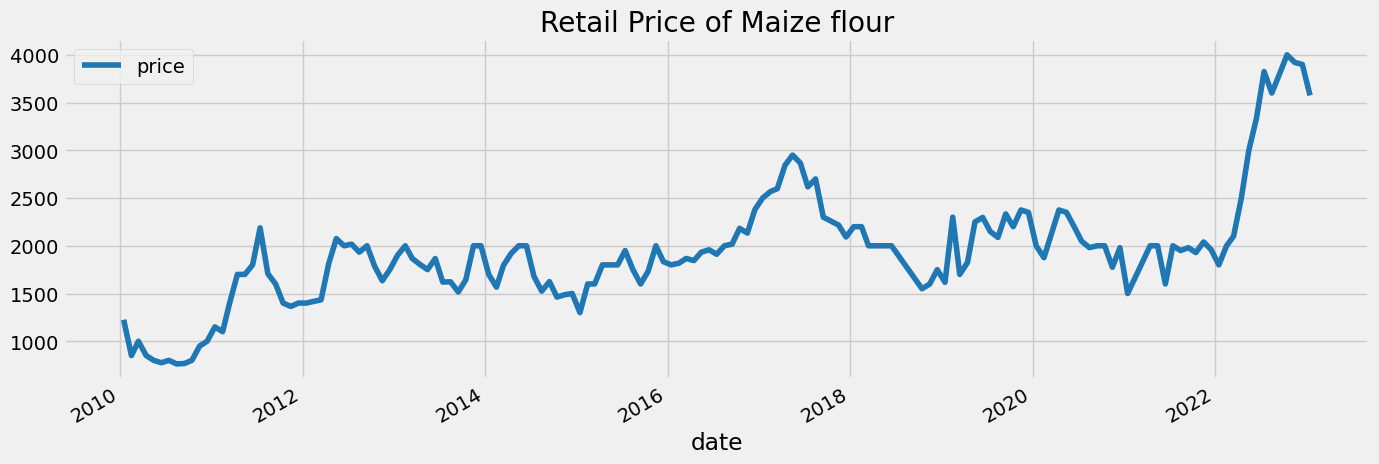

In [7]:
#Data visualisation
cereal_tuber_retail_df.plot(figsize=(15, 5),
                           color=color_pal[0],
                           title='Retail Price of Maize flour')
plt.show()

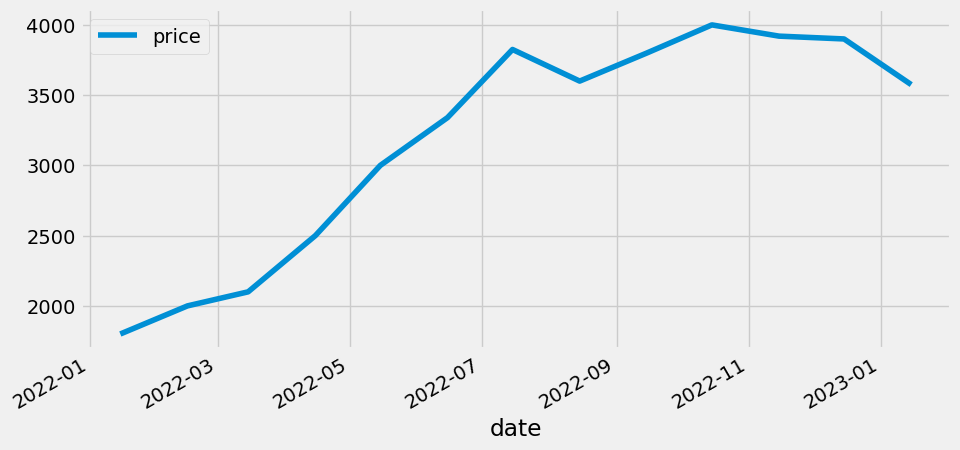

In [8]:
#monthly price distribution
filtered_df = cereal_tuber_retail_df.loc[
    (cereal_tuber_retail_df.index >= '2022-01-15') &
    (cereal_tuber_retail_df.index <= '2023-01-15')
]

filtered_df.plot(figsize=(10, 5))
plt.show()

In [9]:
#splitting the dataset into training and test sets
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=30)
cereal_tuber_retail_df = cereal_tuber_retail_df.sort_index()

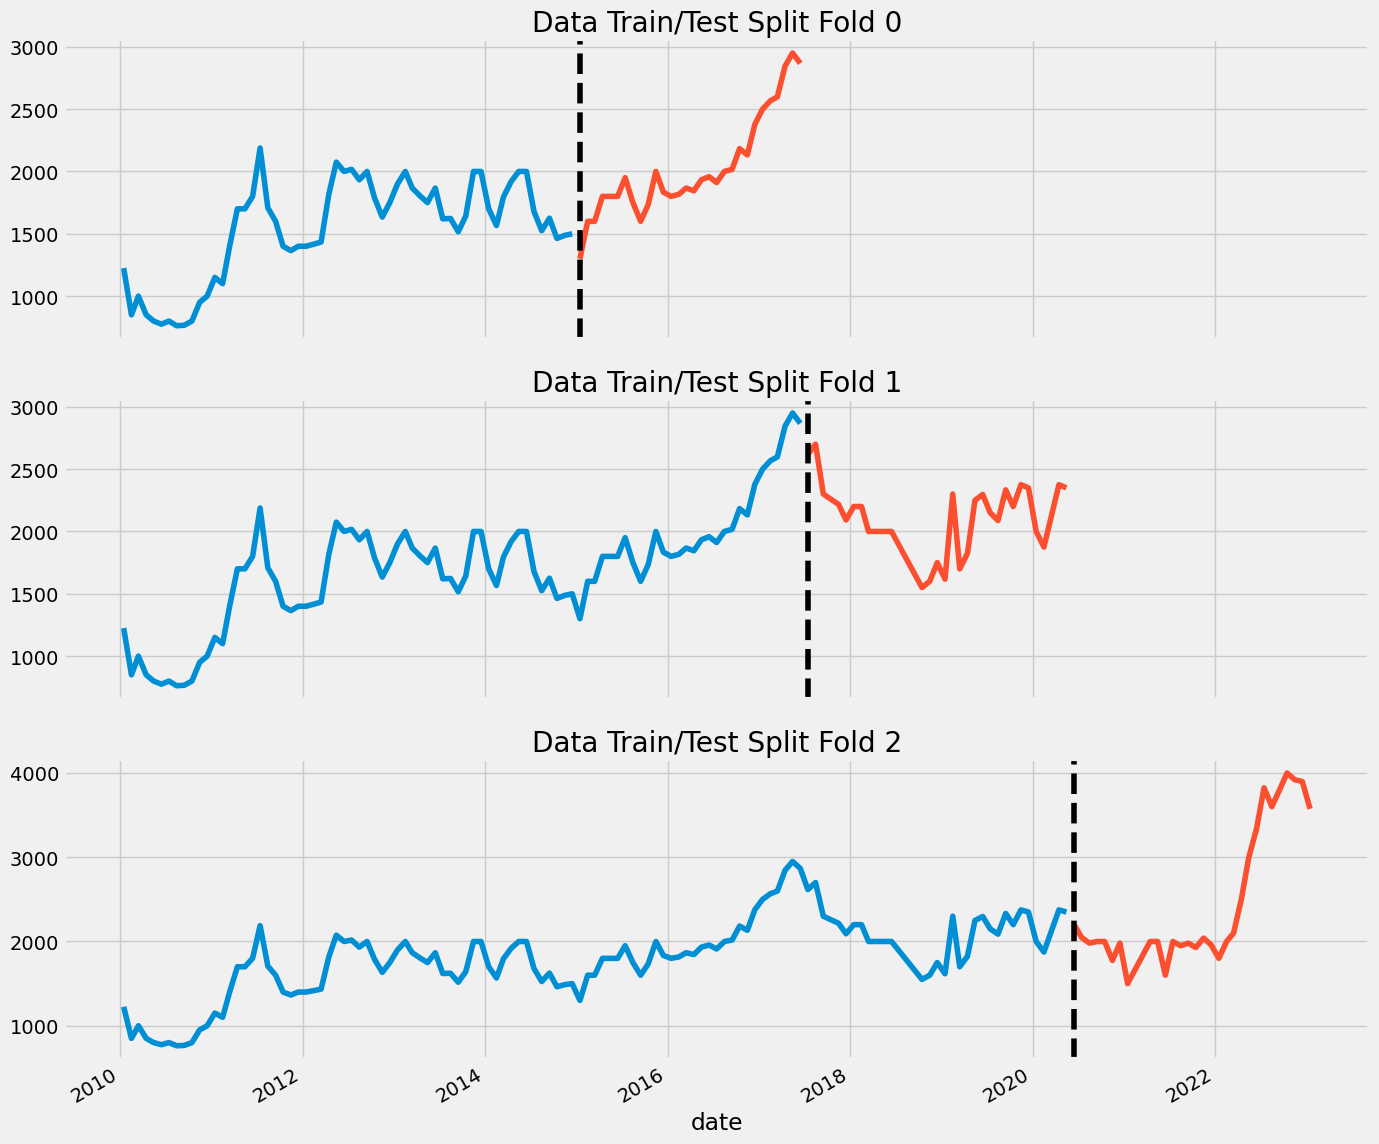

In [10]:
#Visualising the splitting
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(cereal_tuber_retail_df):
    train = cereal_tuber_retail_df.iloc[train_idx]
    test = cereal_tuber_retail_df.iloc[val_idx]
    train['price'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['price'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [11]:
#feature creation
def feature_creation(cereal_tuber_retail_df):
    cereal_tuber_retail_df = cereal_tuber_retail_df.copy()
    cereal_tuber_retail_df["dayofweek"] = cereal_tuber_retail_df.index.dayofweek
    cereal_tuber_retail_df["quarter"] = cereal_tuber_retail_df.index.quarter
    cereal_tuber_retail_df["month"] = cereal_tuber_retail_df.index.month
    cereal_tuber_retail_df["year"] = cereal_tuber_retail_df.index.year
    cereal_tuber_retail_df["dayofyear"] = cereal_tuber_retail_df.index.dayofyear
    cereal_tuber_retail_df["dayofmonth"] = cereal_tuber_retail_df.index.day
    cereal_tuber_retail_df["weekofyear"] = cereal_tuber_retail_df.index.isocalendar().week
    
    return cereal_tuber_retail_df

cereal_tuber_retail_df = feature_creation(cereal_tuber_retail_df)

#Creation of lag features

def add_lags(cereal_tuber_retail_df):
    target_map = cereal_tuber_retail_df['price'].to_dict()
    cereal_tuber_retail_df['lag1'] = (cereal_tuber_retail_df.index - pd.Timedelta('365 days')).map(target_map)
    cereal_tuber_retail_df['lag2'] = (cereal_tuber_retail_df.index - pd.Timedelta('730 days')).map(target_map)
    
    return cereal_tuber_retail_df

cereal_tuber_retail_df = add_lags(cereal_tuber_retail_df)

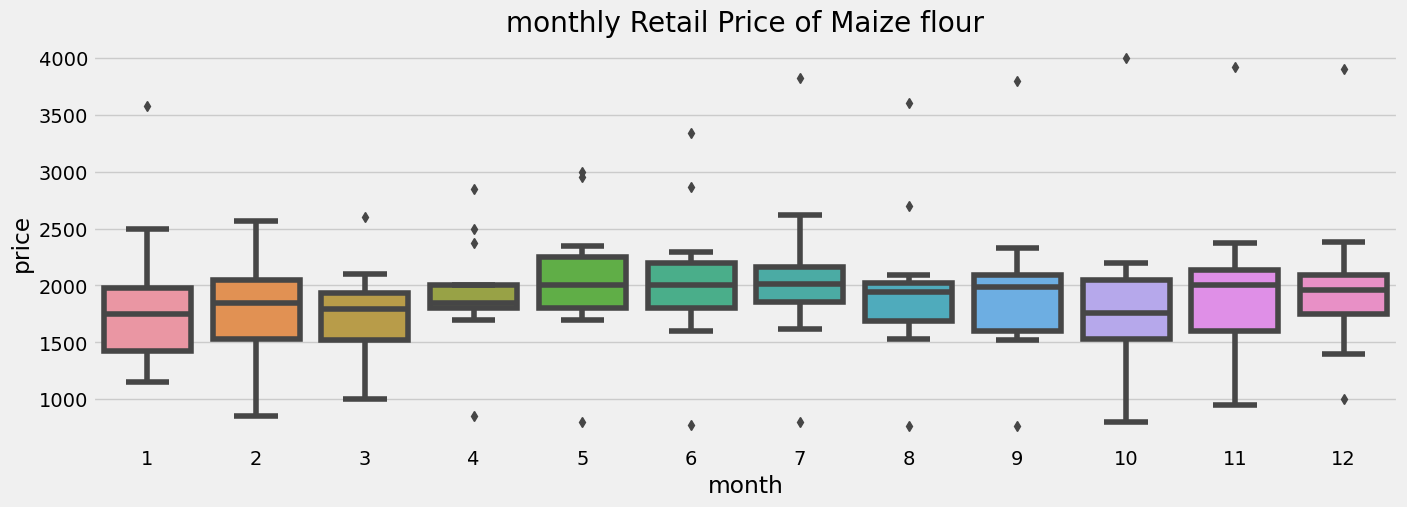

In [12]:
#monthly boxplot for monthly price for MAize flour
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=cereal_tuber_retail_df, x='month' , y='price')
ax.set_title('monthly Retail Price of Maize flour')

plt.show()

In [13]:
#training using cross volidation
tss = TimeSeriesSplit(n_splits=3, test_size=30)
cereal_tuber_retail_df = cereal_tuber_retail_df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(cereal_tuber_retail_df):
    train = cereal_tuber_retail_df.iloc[train_idx]
    test = cereal_tuber_retail_df.iloc[val_idx]

    train = feature_creation(train)
    test = feature_creation(test)

    FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'dayofmonth','year',
                'lag1','lag2']
    TARGET = 'price'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[15:39:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1572.13038	validation_1-rmse:2053.75362
[100]	validation_0-rmse:624.03333	validation_1-rmse:1028.63604
[200]	validation_0-rmse:281.43439	validation_1-rmse:668.34288
[300]	validation_0-rmse:154.62221	validation_1-rmse:551.66729
[400]	validation_0-rmse:105.04054	validation_1-rmse:508.49245
[500]	validation_0-rmse:85.45281	validation_1-rmse:494.59862
[600]	validation_0-rmse:74.58823	validation_1-rmse:491.02506
[700]	validation_0-rmse:67.84740	validation_1-rmse:489.02508
[800]	validation_0-rmse:62.06207	validation_1-rmse:486.24027
[900]	validation_0-rmse:58.08218	validation_1-rmse:485.15025
[999]	validation_0-rmse:53.95406	validation_1-rmse:485.22568
[15:39:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0759

In [14]:
#Retraining all the data
cereal_tuber_retail_df = feature_creation(cereal_tuber_retail_df)

FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'dayofmonth','year',
                'lag1','lag2']

TARGET = 'price'

X_all = cereal_tuber_retail_df[FEATURES]
y_all = cereal_tuber_retail_df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_all, y_all,
       eval_set=[(X_all, y_all)],
       verbose = 100)

#Saving the model as pickle file
with open('trained_model', 'wb') as f:
    pickle.dump(reg, f)
    
model = pickle.load(open('trained_model', 'rb'))

[15:39:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2012.73554
[100]	validation_0-rmse:804.52348
[200]	validation_0-rmse:367.81506
[300]	validation_0-rmse:224.07208
[400]	validation_0-rmse:174.60580
[499]	validation_0-rmse:152.23754


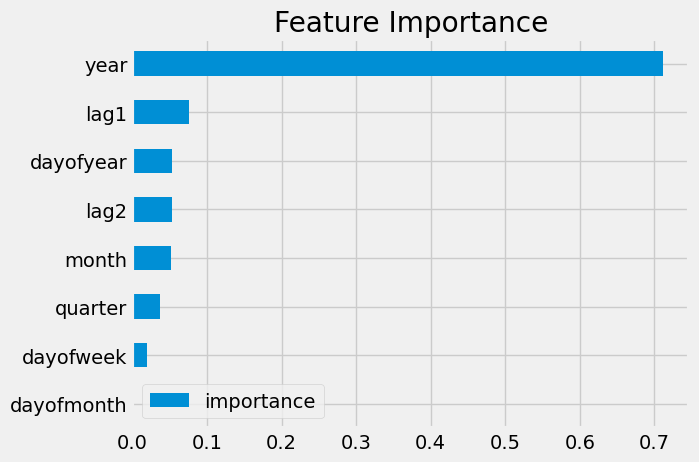

In [15]:
#Explainability
fi = pd.DataFrame(data= reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

plt.show()

In [16]:
#determing the latest dataset
cereal_tuber_retail_df.index.max()

Timestamp('2023-01-15 00:00:00')

In [17]:
#feature creation for monthly prediction
future = pd.date_range('2023-01-15', '2024-01-15', freq='M')
#future = future + pd.DateOffset(days=15)
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
cereal_tuber_retail_df['isFuture'] = False
future_retail = pd.concat([cereal_tuber_retail_df, future_df])
future_retail = feature_creation(future_retail)
future_retail = add_lags(future_retail)

Monthly_future = future_retail.query('isFuture').copy()

In [18]:
Monthly_future

,price,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,isFuture
2023-01-31,NaN,1,1,1,2023,31,31,5,NaN,NaN,True
2023-02-28,NaN,1,1,2,2023,59,28,9,NaN,NaN,True
2023-03-31,NaN,4,1,3,2023,90,31,13,NaN,NaN,True
2023-04-30,NaN,6,2,4,2023,120,30,17,NaN,NaN,True
2023-05-31,NaN,2,2,5,2023,151,31,22,NaN,NaN,True
2023-06-30,NaN,4,2,6,2023,181,30,26,NaN,NaN,True
2023-07-31,NaN,0,3,7,2023,212,31,31,NaN,NaN,True
2023-08-31,NaN,3,3,8,2023,243,31,35,NaN,NaN,True
2023-09-30,NaN,5,3,9,2023,273,30,39,NaN,NaN,True
2023-10-31,NaN,1,4,10,2023,304,31,44,NaN,NaN,True


In [19]:
# Filter Monthly_future DataFrame for '2023-01-15'
prediction_date = pd.to_datetime('2023-02-28')
prediction_data = Monthly_future[Monthly_future.index == prediction_date]

#Making prediction for 2023-02-15 using the trained model
prediction_data['predicts'] = reg.predict(prediction_data[FEATURES])

C:\Users\Kofidence\AppData\Local\Temp\ipykernel_7520\2212512059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_data['predicts'] = reg.predict(prediction_data[FEATURES])


In [20]:
#Prediction for a specific month
prediction_data

,price,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,isFuture,predicts
2023-02-28,NaN,1,1,2,2023,59,28,9,NaN,NaN,True,2031.779663


In [21]:
#Future prediction
Monthly_future['preds'] = reg.predict(Monthly_future[FEATURES])

In [22]:
#Predicted result
Monthly_future

,price,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,isFuture,preds
2023-01-31,NaN,1,1,1,2023,31,31,5,NaN,NaN,True,2010.445312
2023-02-28,NaN,1,1,2,2023,59,28,9,NaN,NaN,True,2031.779663
2023-03-31,NaN,4,1,3,2023,90,31,13,NaN,NaN,True,1979.308838
2023-04-30,NaN,6,2,4,2023,120,30,17,NaN,NaN,True,2049.358398
2023-05-31,NaN,2,2,5,2023,151,31,22,NaN,NaN,True,2049.358398
2023-06-30,NaN,4,2,6,2023,181,30,26,NaN,NaN,True,2049.358398
2023-07-31,NaN,0,3,7,2023,212,31,31,NaN,NaN,True,2042.957520
2023-08-31,NaN,3,3,8,2023,243,31,35,NaN,NaN,True,2212.529053
2023-09-30,NaN,5,3,9,2023,273,30,39,NaN,NaN,True,2173.024170
2023-10-31,NaN,1,4,10,2023,304,31,44,NaN,NaN,True,2175.349609


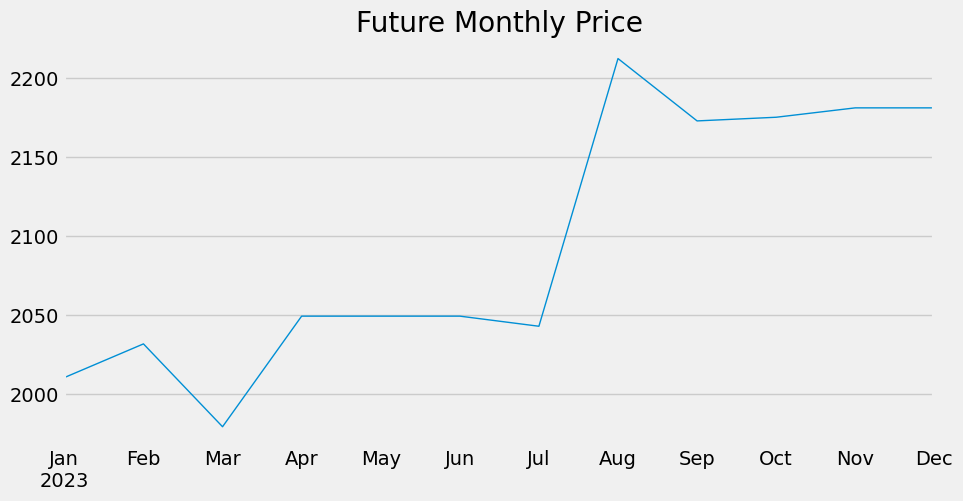

In [23]:
#result visualisation

Monthly_future['preds'].plot(figsize=(10, 5),
                            ms=1,
                            lw=1,
                            title='Future Monthly Price')

plt.show()

In [ ]:
from flask import Flask, render_template, url_for, flash, redirect
from flask import Flask
from flask_wtf import FlaskForm
from wtforms import StringField, SubmitField, PasswordField, SubmitField,SelectField,DateField
from wtforms.validators import DataRequired, email_validator, Length, EqualTo
from datetime import datetime

from flask_mysqldb import MySQL

app = Flask(__name__, static_url_path='/static')
app.config['SECRET_KEY'] = "CTKDANTE"
app.config['MY_SQL HOST'] = "localhost"
app.config['MYSQL_USER'] = "root"
app.config['MYSQL_PASSWORD'] = "dante"
app.config['MYSQL_DB'] = "users_db"

db = MySQL(app)

# creating the form class
class signupForm(FlaskForm):
    firstName = StringField('Enter Name', validators=[DataRequired(), Length(min=2, max=50)])
    secondName = StringField(validators=[DataRequired(), Length(min=2, max=50)])
    email = StringField('Enter email', validators=[DataRequired()])
    phoneNumber = StringField('Enter Number', validators=[DataRequired(), Length(min=10, max=13)])
    password = PasswordField('Enter password', validators=[DataRequired()])
    confirm_password = PasswordField('Confirm passord', validators=[DataRequired(), EqualTo('password')])
    submit = SubmitField('Register')


#creating another for class for user input
class user_input(FlaskForm):
    commodity = SelectField('Choose commodity To foreast', choices=[('sg', 'Sugar'),
                 ('mz', 'Maize'), ('rc', 'Rice'), ('bn', 'Beans')])
    
    forecasted_date = SelectField('Choose Month in which to forecast', choices=[('Jan', 'January'),
    ('Feb', 'Febuary'), ('Mar', 'March'), ('Apr', 'April'), ('May', 'May'), ('Jun', 'June'), 
    ('Jul', 'July'), ('Aug', 'August'), ('Sep', 'September'), ('Oct', 'October'), ('Nov', 'November'), ('Dec', 'December')])
    submit = SubmitField('Forecast')
    

#index.html absolute path
directory = os.path.abspath('index.html')

@app.route('/')
def index():
    return render_template('index.html')
   

@app.route('/index.html')
def index1():
    return render_template('index.html')

#signup route
@app.route('/sign_up.html', methods=['GET', 'POST'])
def sign_up():
    
    form = signupForm()

    if form.validate_on_submit():
        print("Form validation successful")
        firstName = form.firstName.data
        secondName = form.secondName.data
        email = form.email.data
        phoneNumber =form.phoneNumber.data
        password = form.password.data
        password2 = form.confirm_password.data
        date_added = datetime.utcnow()
        

        cur = db.connection.cursor()
        cur.execute(" INSERT INTO user_info (FirstName, SecondName, email, phoneNumber,password, date_added ) VALUES (%s,%s,%s,%s,%s,%s)", (firstName, secondName, email, phoneNumber, password,date_added ))
        db.connection.commit()
        cur.close()
        return redirect(url_for('trends'))
        
    else: flash(form.errors)


        
           
    
    return render_template('sign_up.html',  
    form = form)

@app.route('/dashboard.html', methods = ['GET', 'POST']) 
def dashboard():
    form = user_input()
    # logic for choosing date
    

    return render_template('dashboard.html', form = form)


#Trends route
@app.route('/trends.html')
def trends():
    return render_template('trends.html')

#'About us' Route
@app.route('/about.html')
def about():
    return render_template('about.html')

if __name__ == "__main__":
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [23/Jun/2023 15:39:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Jun/2023 15:40:00] "GET /dashboard.html HTTP/1.1" 200 -
127.0.0.1 - - [23/Jun/2023 15:40:12] "POST /dashboard.html HTTP/1.1" 200 -
127.0.0.1 - - [23/Jun/2023 15:41:28] "POST /dashboard.html HTTP/1.1" 200 -
